In [1]:
import torch
import h5py
import matplotlib.pyplot as plt

import common
from core import *

In [2]:
data = h5py.File("data/out_poisson/poisson.h5")

geometry = torch.tensor(data["/Mesh/mesh/geometry"][...], dtype=torch.float32)
topology = torch.tensor(data["/Mesh/mesh/topology"][...], dtype=torch.int32)
func = torch.tensor(data["/Function/f/0"][...], dtype=torch.float64)

print(geometry.shape)
print(topology.shape)
print(func.shape)

torch.Size([81, 2])
torch.Size([128, 3])
torch.Size([81, 1])


In [3]:
topology.shape

torch.Size([128, 3])

In [4]:
def on_boundary(x):
    n = x.shape[0]
    return torch.isclose(x[:, 0], 0.0*torch.ones(n)) | \
           torch.isclose(x[:, 0], 1.0*torch.ones(n)) | \
           torch.isclose(x[:, 1], 0.0*torch.ones(n)) | \
           torch.isclose(x[:, 1], 1.0*torch.ones(n))

In [5]:
# get edges from topology
senders, receivers = common.topology_to_edges(topology) # two way connectivity implied
senders = senders.long()
receivers = receivers.long()

# compute mesh distances
senders_pos = geometry[senders]
receivers_pos = geometry[receivers]
mesh_distances = torch.sqrt((senders_pos[:, 0] - receivers_pos[:, 0])**2 + (senders_pos[:, 1] - receivers_pos[:, 1])**2)

# create edge set
edgeset = EdgeSet(senders, receivers, mesh_distances)

# create node features
node_types = F.one_hot(on_boundary(geometry).long())
node_features = torch.cat([node_types, func], dim=1)

# create graph
graph = MultiGraph(node_features, edgeset)

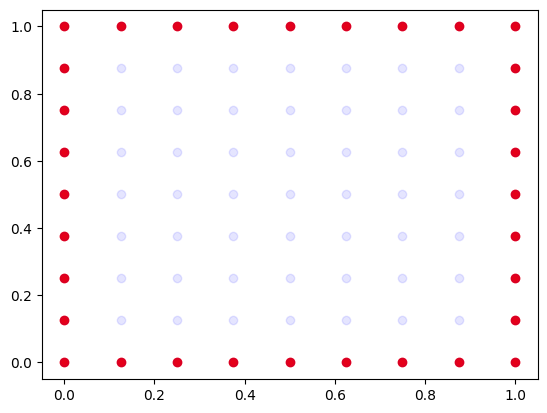

In [6]:
# visualise nodes with their types
x_b, y_b = torch.unbind(geometry[on_boundary(geometry)], dim=1)
x, y = torch.unbind(geometry, dim=1)
plt.scatter(x_b, y_b, c='r')
plt.scatter(x, y, c='b', alpha=0.1)
plt.show()

/home/lurker/miniconda3/envs/torch/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

Your build of VTK does not have the proper web modules enabled.
These modules are typically enabled by default with the
`-DVTK_GROUP_ENABLE_Web:STRING=WANT` build flag.

Conda users: This is a known issue with the conda-forge VTK feedstock.
See https://github.com/conda-forge/vtk-feedstock/pull/258


Falling back to a static output.
  warnings.warn(


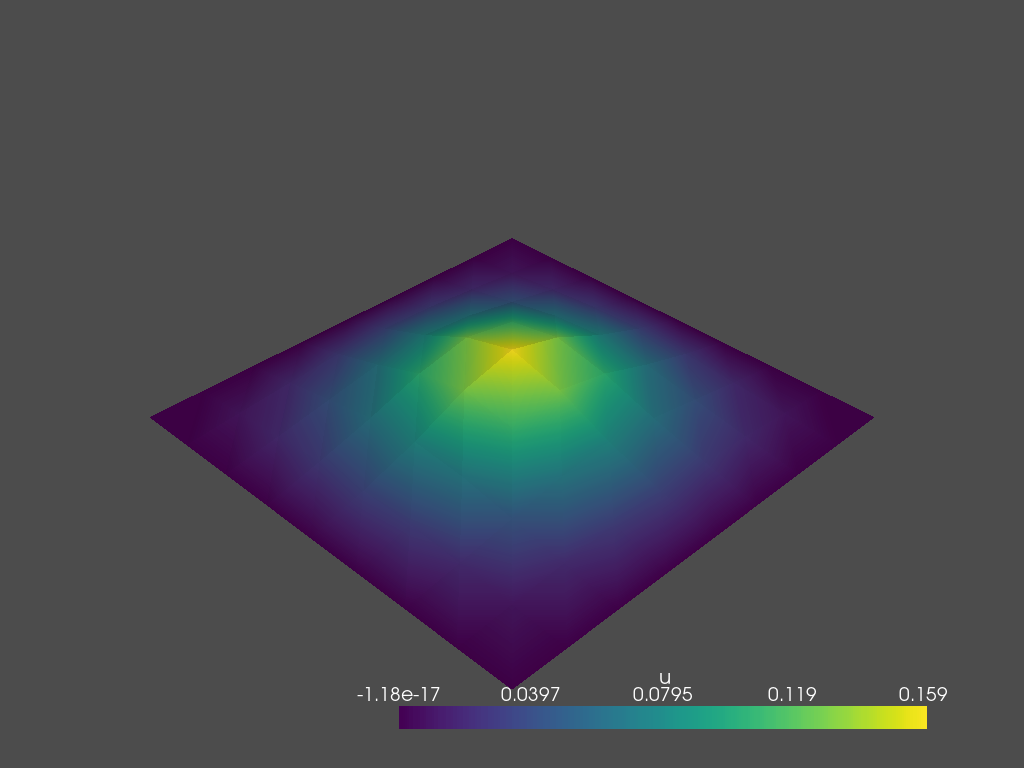

In [12]:
# display solution
import pyvista
pyvista.set_jupyter_backend('trame')

n_cells = topology.shape[0]
n_points = geometry.shape[0]

cells_vtk = torch.cat([3*torch.ones(n_cells)[:, None], topology], dim=1).int().flatten().numpy()
celltypes = [pyvista.CellType.TRIANGLE] * n_cells
points = torch.cat([geometry, torch.zeros(n_points)[:, None]], dim=1).numpy()

grid = pyvista.UnstructuredGrid(cells_vtk, celltypes, points)
grid.point_data["u"] = func.numpy()
grid.set_active_scalars("u")
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=False)
warped = grid.warp_by_scalar()
plotter.add_mesh(warped)
plotter.show()